# YANS 2024 ハッカソン 川柳ベースライン実装

## 環境の準備

In [ ]:
!pip install datasets openai pillow matplotlib loguru

## 準備

In [ ]:
# ベースライン実装のリポジトリをclone
!git clone https://github.com/ryokan0123/yans-2024-hackathon-baseline
# utilsをノートブックで使用するため、フォルダを移動
!cp -r yans-2024-hackathon-baseline/utils ./

fatal: destination path 'yans-2024-hackathon-baseline' already exists and is not an empty directory.


In [ ]:
# OpenAI APIキーを設定
%env OPENAI_API_KEY=sk-...

env: OPENAI_API_KEY=sk-...


In [ ]:
# notebook上でOpenAI APIを非同期でまとめて呼び出す場合に必要
import nest_asyncio

nest_asyncio.apply()

In [ ]:
# google driveをマウントし、推論結果ファイルをそこに保存できるようにしておく
from google.colab import drive

drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [ ]:
# ドライブが正しくマウントできているか確認
!ls ./drive/MyDrive

...


## データセットの確認

In [ ]:
from datasets import load_dataset

dataset = load_dataset("YANS-official/ogiri-debug", split="test")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['image', 'odai_id', 'odai', 'type', 'responses'],
    num_rows: 3
})

image_to_text
画像で一言


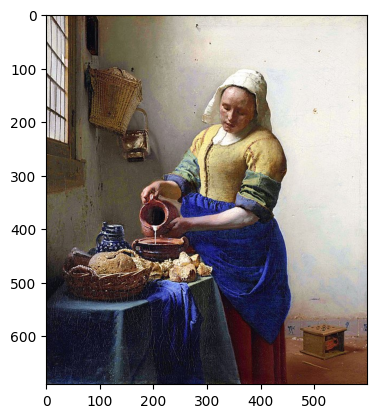


text_to_text
この学会、なんだか疲れるなぁ…どんなの？

image_text_to_text
「どろぼうの仲間だ」「ちがうよ！わしは[空欄]だけだ」


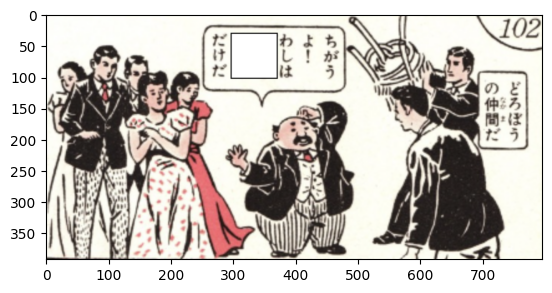

In [ ]:
import matplotlib.pyplot as plt

for item in dataset:
  print(item["type"])
  print(item["odai"])
  if "image" in item["type"]:
    plt.imshow(item["image"])
    plt.show()
  print()

## 提出ファイルの作成

In [ ]:
import datasets
import json
from typing import Any
import argparse
import tqdm
from loguru import logger

from utils.chatgpt import OpenAIChatAPI
from utils.data_util import batch_iter, encode_image_to_base64

In [ ]:
def item_to_api_input(item: dict[str, Any]) -> list[dict[str, Any]]:
    """
    大喜利データセットの各アイテムを ChatGPT API への入力形式に変換する関数。
    例としてシンプルなプロンプトを実装していますが、適宜変更して使用してください。
    """
    messages = [
        {
            "role": "system",
            "content": "あなたはユーモアに溢れた大喜利 AI です。与えられたお題に対して、面白い回答をお願いします。",
        }
    ]
    if item["type"] == "text_to_text":
        # テキストのみを入力としたお題
        messages.append(
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": item["odai"]},
                ],
            }
        )

    elif item["type"] == "image_to_text":
        # ローカルの画像を OpenAI API に渡す場合は、画像を base64 エンコードした文字列を渡す
        # `encode_image_to_base64`で PIL 形式の画像を base64 エンコードした文字列に変換
        image_base64 = encode_image_to_base64(item["image"])

        # 画像で一言のお題
        messages.append(
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "次の画像を見て、何か面白い一言をお願いします。",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_base64}",
                            "detail": "low", # 低解像度モード。API使用量を節約するために基本このオプションを使用してください
                        },
                    },
                ],
            }
        )

    elif item["type"] == "image_text_to_text":
        image_base64 = encode_image_to_base64(item["image"])

        # 画像中の空欄を埋めるお題
        messages.append(
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"画像に含まれる{item['odai']}というテキストの[空欄]を面白くなるように埋めてください。",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_base64}",
                            "detail": "low", # 低解像度モード。API使用量を節約するために基本このオプションを使用してください
                        },
                    },
                ],
            }
        )
    else:
        raise ValueError(f"Invalid type: {item['type']}")

    return messages

In [ ]:
dataset_name = "YANS-official/ogiri-debug"
batch_size = 4
output_file = "./drive/MyDrive/submission.jsonl"

logger.info(f"Loading data from {dataset_name}...")
dataset = datasets.load_dataset(dataset_name, split="test")

openai_api = OpenAIChatAPI()

logger.info("Generating model outputs...")
# バッチごとにモデルの出力を取得
model_outputs: list[dict[str, Any]] = []
with tqdm.tqdm(total=len(dataset)) as pbar:
    for i, items in enumerate(batch_iter(dataset, batch_size=batch_size)):
        api_input_list = [item_to_api_input(item) for item in items]
        responses = openai_api.batch_generate_chat_response(api_input_list)
        model_outputs += [
            {**item, "model_output": res} for item, res in zip(items, responses)
        ]
        pbar.update(len(items))

logger.info(f"Saving model outputs to {output_file}...")
# モデルの出力を保存
with open(output_file, "w") as f:
    for output in model_outputs:
        output.pop("image")  # 画像は出力に含めない
        f.write(json.dumps(output, ensure_ascii=False, default=str) + "\n")

2024-08-30 12:46:17.915 | INFO     | __main__:<cell line: 5>:5 - Loading data from YANS-official/ogiri-debug...
2024-08-30 12:46:18.983 | INFO     | __main__:<cell line: 10>:10 - Generating model outputs...
100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
2024-08-30 12:46:22.494 | INFO     | __main__:<cell line: 22>:22 - Saving model outputs to ./drive/MyDrive/submission.jsonl...
